In [1]:
#!/usr/bin/env python

import math
import healpy as hp
import numpy as np
import sys
import time
import os
sys.path.insert(1, '../../../PySSC/')

from classy import Class
import PySSC
from scipy.stats import norm
from matplotlib import pyplot as plt

from numcosmo_py import Ncm, Nc

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

In [2]:
cosmo = Nc.HICosmoDEXcdm()
cosmo.props.H0 = 67.81
cosmo.props.Omegac = 0.2612
cosmo.props.Omegab = 0.0486
cosmo.props.Omegax = 1 - 0.0486 - 0.2612
cosmo.props.w = -1.0

reion = Nc.HIReionCamb.new()
prim = Nc.HIPrimPowerLaw.new()

cosmo.add_submodel(reion)
cosmo.add_submodel(prim)

dist = Nc.Distance.new(2.0)

tf = Nc.TransferFunc.new_from_name("NcTransferFuncEH")

psml = Nc.PowspecMLTransfer.new(tf)
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()
prim.props.n_SA = 0.9660
# print(0.82505858,cosmo.sigma8(psf),cosmo.Omega_k0())

prim.props.ln10e10ASA = 3.027449698161606
# print(0.82505858, cosmo.sigma8(psf))

z_obs = Ncm.Vector.new_array(np.linspace(0.1, 0.8, 8))
lnM_obs = Ncm.Vector.new_array(np.linspace(np.log(10) * 14.0, np.log(10) * 15, 2))

print(z_obs.dup_array())
print(lnM_obs.dup_array())
print(prim.props.ln10e10ASA)

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8]
[32.23619130191664, 34.53877639491069]
3.027449698161606


# Construct the $S_{ij}$  Matrix

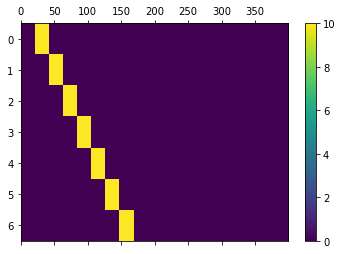

In [3]:
nz = 400
z_arr = np.linspace(0, 1.9, num=nz + 1)[1:]

nbins_T = z_obs.len() - 1

kernels_T = np.zeros((nbins_T, nz))
for i in range(nbins_T):
    zminbin = z_obs.get(i)
    zmaxbin = z_obs.get(i + 1)
    Dz = zmaxbin - zminbin

    for iz in range(nz):
        z = z_arr[iz]
        if (z > zminbin) and (z <= zmaxbin):
            kernels_T[i, iz] = 1 / Dz

fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.matshow(kernels_T)
ax.set_aspect("auto")
plt.colorbar(im)
pass

In [4]:
NSIDE = 2 * 512
NPIX = hp.nside2npix(NSIDE)
m = np.zeros(hp.nside2npix(NSIDE))
pix_theta_ecl, pix_phi_ecl = hp.pix2ang(NSIDE, np.arange(NPIX))

# Guaranteed mask
mask1_guaranteed = np.zeros(NPIX)
mask2_guaranteed = np.zeros(NPIX)
mask3_guaranteed = np.zeros(NPIX)

mask1_guaranteed_condition = (
    (pix_phi_ecl > 3.0 * np.pi / 4.0)
    & (pix_phi_ecl < 13.0 * np.pi / 12.0)
    & (pix_theta_ecl < np.pi / 2.0 - 30.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 80.0 * np.pi / 180)
)
mask2_guaranteed_condition = (
    (pix_phi_ecl > 11.0 * np.pi / 6.0)
    & (pix_theta_ecl < np.pi / 2.0 - 20.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 40.0 * np.pi / 180)
)
mask3_guaranteed_condition = (
    (pix_phi_ecl < np.pi / 4.0)
    & (pix_theta_ecl < np.pi / 2.0 - 20.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 40.0 * np.pi / 180)
)

mask1_guaranteed[mask1_guaranteed_condition] = 1
mask2_guaranteed[mask2_guaranteed_condition] = 1
mask3_guaranteed[mask3_guaranteed_condition] = 1

mask_guaranteed = mask1_guaranteed + mask2_guaranteed + mask3_guaranteed

# Total mask
mask1_full = np.zeros(NPIX)
mask2_full = np.zeros(NPIX)
mask3_full = np.zeros(NPIX)

mask1_full_condition = (
    (pix_phi_ecl > 2.0 * np.pi / 3.0)
    & (pix_phi_ecl < 3.0 * np.pi / 2.0)
    & (pix_theta_ecl < np.pi / 2.0 - 10.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 80.0 * np.pi / 180)
)
mask2_full_condition = (
    (pix_phi_ecl > 11.0 * np.pi / 6.0)
    & (pix_theta_ecl < np.pi / 2.0)
    & (pix_theta_ecl > np.pi / 2.0 - 45.0 * np.pi / 180)
)
mask3_full_condition = (
    (pix_phi_ecl < np.pi / 4.0)
    & (pix_theta_ecl < np.pi / 2.0)
    & (pix_theta_ecl > np.pi / 2.0 - 45.0 * np.pi / 180)
)

mask1_full[mask1_full_condition] = 1
mask2_full[mask2_full_condition] = 1
mask3_full[mask3_full_condition] = 1

mask_full = mask1_full + mask2_full + mask3_full

`S matrices`

In [5]:
# Full sky
t0 = time.time()
S_lacasa = PySSC.Sij(z_arr, kernels_T, cosmo_Class=cosmo)
t1 = time.time()
print("Full sky time (seconds) = " + str(t1 - t0))

S_full = Ncm.Matrix.new(S_lacasa.shape[0], S_lacasa.shape[1])
for i in range(len(S_lacasa)):
    for j in range(len(S_lacasa[i])):
        S_full.set(i, j, S_lacasa[i][j])


# Partial-Sky guaranteed
t0 = time.time()
S_lacasa = PySSC.Sij_psky(z_arr, kernels_T, mask=mask_guaranteed, cosmo_Class=cosmo)
t1 = time.time()
print("Partial sky guaranteed time (seconds) = " + str(t1 - t0))

S_guaranteed = Ncm.Matrix.new(S_lacasa.shape[0], S_lacasa.shape[1])
for i in range(len(S_lacasa)):
    for j in range(len(S_lacasa[i])):
        S_guaranteed.set(i, j, S_lacasa[i][j])


# Partial-Sky maximal
t0 = time.time()
S_lacasa = PySSC.Sij_psky(z_arr, kernels_T, mask=mask_full, cosmo_Class=cosmo)
t1 = time.time()
print("Partial sky maximal time (seconds) = " + str(t1 - t0))

S_maximal = Ncm.Matrix.new(S_lacasa.shape[0], S_lacasa.shape[1])
for i in range(len(S_lacasa)):
    for j in range(len(S_lacasa[i])):
        S_maximal.set(i, j, S_lacasa[i][j])

Full sky time (seconds) = 0.5360586643218994
Partial sky guaranteed time (seconds) = 31.828424215316772
Partial sky maximal time (seconds) = 18.403428077697754


# Define proxy modelling

In [6]:
cluster_m = Nc.ClusterMassNodist(lnM_min=np.log(10) * 14.0, lnM_max=np.log(10) * 16 )
cluster_z = Nc.ClusterRedshiftNodist(z_min=0.0, z_max=2.0)

# Initialize the `ClusterAbundance` object

In [7]:
mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta(200.0)

hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hbias_Tinker = Nc.HaloBiasTinker.new(hmf)
cad = Nc.ClusterAbundance.new(hmf, hbias_Tinker)

# Data model

$f(x_i)$ for the Gaussian distribution $$-2\ln L = \sum_{ij}\left[(f(x_i) - y_i)C^{-1}_{ij}(f(x_j) - y_j)\right] + \dots$$

In [8]:
mset = Ncm.MSet.new_array([cosmo,cluster_m,cluster_z])


ncounts_gauss = Nc.DataClusterNCountsGauss.new(cad)
ncounts_gauss.set_size((z_obs.len()-1)*(lnM_obs.len()-1))
ncounts_gauss.set_init(True)
ncounts_gauss.set_fix_cov(False)
ncounts_gauss.use_norma(True)
ncounts_gauss.set_z_obs(z_obs)
ncounts_gauss.set_lnM_obs(lnM_obs)
rng = Ncm.RNG.seeded_new (None, 42)
print(ncounts_gauss.get_fix_cov()) 

False


# Creating the fit object and calculating the MC

`No SSC`

In [9]:
print("No SSC")


guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)
ncounts_gauss.set_has_ssc(False)
ncounts_gauss.resample(mset, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "% 22.15g", True)
ncounts_gauss.peek_cov().log_vals("cov: ", "% 22.15g")

dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset))

mset.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD
)

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)  # 1


nwalkers = int(math.ceil(200))  # 500
ssize = 200000  # 1000000

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(3)

fitmc.set_data_file("mc_nossc.fits")

fitmc.start_run()
fitmc.run(ssize/nwalkers)
fitmc.end_run()

print("Full sky maximal time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")


No SSC
y:       1404.48257636951       3188.88172345454       4912.77079830035       6414.27963953379       7190.94067360189        7419.3108729704       7193.34466396361
cov:        1451.02844822162                      0                      0                      0                      0                      0                      0
cov:                       0        3238.3698073803                      0                      0                      0                      0                      0
cov:                       0                      0       5025.38346233246                      0                      0                      0                      0
cov:                       0                      0                      0           6399.3104724                      0                      0                      0
cov:                       0                      0                      0                      0       7185.56470314239                      0                  

In [10]:
ntests = 100.0
mcat = fitmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)

#----------------------------------------------------------------------------------
# NcmMSetCatalog: Calculating catalog effective sample size from chain 500 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   500 
# NcmMSetCatalog: - number of points left:    500 
# NcmMSetCatalog: - worst parameter:          NcHIPrim:ln10e10ASA[03]
# NcmMSetCatalog: - worst parameter ess:      500.00
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    500.00 500.00 500.00 500.00
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Applying the Heidelberger and Welch's convergence diagnostic from chain 500 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - worst parameter:          NcHICosmo:Omegac[01]
# NcmMSetCatalog: - worst parameter pvalue:    2.11%
# NcmMSetCatalog: - worst parameter ar order:


(process:5665): NUMCOSMO-WARNING **: 14:27:05.928: _ncm_mset_catalog_get_post_lnnorm_sum: catalog too small to estimate error on the posterior norm.


`Full-Sky`

In [11]:
print("Full Sky")

guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)
ncounts_gauss.set_has_ssc(True)
ncounts_gauss.set_s_matrix(S_full)
ncounts_gauss.resample(mset, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "% 22.15g", True)
ncounts_gauss.peek_cov().log_vals("cov: ", "% 22.15g")

to_fix_cov = ncounts_gauss.peek_cov()

dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset))

mset.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD
)

nwalkers = int(math.ceil(200))  # 500
ssize = 200000  # 1000000

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(3)

fitmc.set_data_file("mc_fullsky.fits")

fitmc.start_run()
fitmc.run(ssize/nwalkers)
fitmc.end_run()

print("Full sky maximal time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")


Full Sky
y:       1405.88334667074       3203.56113335751         4947.918987836        6414.7672448416       7220.37516318559       7373.47176652723        7252.7540396646
cov:        1748.45484759344      -113.378231024948      -38.2273605690352      -17.6063909036728      -9.82618747848274      -5.08792612574883      -2.36904247775204
cov:       -113.378231024948       3868.93891789775      -194.679196834926      -71.1673450281565      -30.4660851052073      -15.6213906534653      -8.28690405249909
cov:       -38.2273605690352      -194.679196834926       5945.74766315903      -244.465351296618      -93.2154815455534      -37.1609564572655      -18.7890048015636
cov:       -17.6063909036728      -71.1673450281565      -244.465351296618       7482.52189539317      -270.435874537766      -100.341882421477      -39.6118733912512
cov:       -9.82618747848274      -30.4660851052073      -93.2154815455534      -270.435874537766       8292.19630686619      -253.601372125959      -97.493602

# NcmMSetCatalog: Current mean:   76.776       0.24495     -1.2045       2.9552     
# NcmMSetCatalog: Current msd:   -nan         -nan         -nan         -nan        
# NcmMSetCatalog: Current sd:    -nan         -nan         -nan         -nan        
# NcmMSetCatalog: Current var:   -nan         -nan         -nan         -nan        
# NcmMSetCatalog: Current tau:    1            1            1            1          
# Task:NcmFitMC, completed: 1 of 500, elapsed time: 00:01:37.2975
# Task:NcmFitMC, mean time: 00:01:37.2834 +/- 00:00:   -nan
# Task:NcmFitMC, time left: 13:29:04.4206 +/- 00:00:   -nan
# Task:NcmFitMC, current time:        Thu Aug 31 2023, 14:28:43
# Task:NcmFitMC, estimated to end at: Fri Sep 01 2023, 03:57:48 +/- 00:00:   -nan
# NcmMSetCatalog: Current mean:   75.623       0.25754     -1.0233       3.0411     
# NcmMSetCatalog: Current msd:    0.45743      0.0021705    0.031931     0.021414   
# NcmMSetCatalog: Current sd:     1.3723       0.0065115    0.095794     

In [12]:
ntests = 100.0
mcat = fitmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)

#----------------------------------------------------------------------------------
# NcmMSetCatalog: Calculating catalog effective sample size from chain 500 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   500 
# NcmMSetCatalog: - number of points left:    500 
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter ess:      500.00
# NcmMSetCatalog: - worst parameter ar order: 1   
# NcmMSetCatalog: - ess's:                    500.00 500.00 569.07 569.53
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Applying the Heidelberger and Welch's convergence diagnostic from chain 500 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - worst parameter:          NcHIPrim:ln10e10ASA[03]
# NcmMSetCatalog: - worst parameter pvalue:   80.67%
# NcmMSetCatalog: - worst parameter ar order: 0  


(process:5665): NUMCOSMO-WARNING **: 16:15:51.125: _ncm_mset_catalog_get_post_lnnorm_sum: catalog too small to estimate error on the posterior norm.


`Partial-Sky guaranteed`

In [13]:
print("Partial sky guaranteed")

guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)
ncounts_gauss.set_s_matrix(S_guaranteed)
ncounts_gauss.resample(mset, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)


dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset))

mset.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD
)

nwalkers = int(math.ceil(200))  # 500
ssize = 200000  # 1000000

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(3)

fitmc.set_data_file("mc_partialskyguranteed.fits")

fitmc.start_run()
fitmc.run(ssize/nwalkers)
fitmc.end_run()


print("Partial sky guaranteed time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")



Partial sky guaranteed
y: 1524.109 3309.469 4934.217 6489.299 7137.619 7519.358 6841.631
0.8243645109978733
# NcmFitMC: No RNG was defined, using algorithm: `mt19937' and seed: 236772100.
#----------------------------------------------------------------------------------
# NcmFitMC: Calculating [000500] Monte Carlo fits [from-model]
# Task:NcmFitMC, started at: Thu Aug 31 2023, 16:15:51


# NcmMSetCatalog: Current mean:   81.788       0.2751      -0.71013      3.3225     
# NcmMSetCatalog: Current msd:   -nan         -nan         -nan         -nan        
# NcmMSetCatalog: Current sd:    -nan         -nan         -nan         -nan        
# NcmMSetCatalog: Current var:   -nan         -nan         -nan         -nan        
# NcmMSetCatalog: Current tau:    1            1            1            1          
# Task:NcmFitMC, completed: 1 of 500, elapsed time: 00:02:04.2686
# Task:NcmFitMC, mean time: 00:02:04.2544 +/- 00:00:   -nan
# Task:NcmFitMC, time left: 17:13:22.9471 +/- 00:00:   -nan
# Task:NcmFitMC, current time:        Thu Aug 31 2023, 16:17:55
# Task:NcmFitMC, estimated to end at: Fri Sep 01 2023, 09:31:18 +/- 00:00:   -nan
# NcmMSetCatalog: Current mean:   84.252       0.25264     -1.0719       3.0554     
# NcmMSetCatalog: Current msd:    0.67084      0.0053512    0.074954     0.043146   
# NcmMSetCatalog: Current sd:     2.0125       0.016054     0.22486      

In [14]:
ntests = 100.0
mcat = fitmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)

#----------------------------------------------------------------------------------
# NcmMSetCatalog: Calculating catalog effective sample size from chain 500 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   500 
# NcmMSetCatalog: - number of points left:    500 
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter ess:      571.81
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    571.81 505.25 611.78 500.00
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Applying the Heidelberger and Welch's convergence diagnostic from chain 500 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         18  
# NcmMSetCatalog: - worst parameter:          NcHICosmo:w[02]
# NcmMSetCatalog: - worst parameter pvalue:    1.75%
# NcmMSetCatalog: - worst parameter ar order: 1   
# NcmM


(process:5665): NUMCOSMO-WARNING **: 18:16:30.238: _ncm_mset_catalog_get_post_lnnorm_sum: catalog too small to estimate error on the posterior norm.


`Partial Sky maximal`

In [15]:
print("Partial Sky maximal area")

maximal_area = 10009.97
cad.set_area(maximal_area * (np.pi / 180) ** 2)
ncounts_gauss.set_s_matrix(S_maximal)
ncounts_gauss.resample(mset, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)


dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset))

mset.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD
)

nwalkers = int(math.ceil(200))  # 500
ssize = 200000  # 1000000

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(3)

fitmc.set_data_file("mc_partialskymaximal.fits")

fitmc.start_run()
fitmc.run(ssize/nwalkers)
fitmc.end_run()


print("Partial sky maximal time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")

Partial Sky maximal area
y: 4576.414 10425.598 16660.456 21383.883 24419.887 24320.718 23860.253
0.8321915957692522
# NcmFitMC: No RNG was defined, using algorithm: `mt19937' and seed: 711887421.
#----------------------------------------------------------------------------------
# NcmFitMC: Calculating [000500] Monte Carlo fits [from-model]
# Task:NcmFitMC, started at: Thu Aug 31 2023, 18:16:30
# NcmMSetCatalog: Current mean:   102.45       0.23714     -1.2139       3.0216     
# NcmMSetCatalog: Current msd:   -nan         -nan         -nan         -nan        
# NcmMSetCatalog: Current sd:    -nan         -nan         -nan         -nan        
# NcmMSetCatalog: Current var:   -nan         -nan         -nan         -nan        
# NcmMSetCatalog: Current tau:    1            1            1            1          
# Task:NcmFitMC, completed: 1 of 500, elapsed time: 00:01:37.1438
# Task:NcmFitMC, mean time: 00:01:37.0300 +/- 00:00:   -nan
# Task:NcmFitMC, time left: 13:26:57.9510 +/- 00:00

In [ ]:
ntests = 100.0
mcat = fitmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)

#----------------------------------------------------------------------------------
# NcmMSetCatalog: Calculating catalog effective sample size from chain 200 => 0 using 100 blocks:


# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   200 
# NcmMSetCatalog: - number of points left:    200 
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter ess:      200.00
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    200.00 200.00 200.00 200.00
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Applying the Heidelberger and Welch's convergence diagnostic from chain 200 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - worst parameter:          NcHICosmo:Omegac[01]
# NcmMSetCatalog: - worst parameter pvalue:   13.13%
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - target pvalue:             1.70%
# NcmMSetCatalog: - pvalues:                  55.13% 13.13% 15.24% 74.82%
#-------------------------------------------------------


(process:3826): NUMCOSMO-WARNING **: 13:11:01.600: _ncm_mset_catalog_get_post_lnnorm_sum: catalog too small to estimate error on the posterior norm.


`Fixed Covariance`

In [ ]:
print("Full Sky fixed cov")

guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)
ncounts_gauss.set_has_ssc(True)
ncounts_gauss.set_s_matrix(S_full)
ncounts_gauss.resample(mset, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "% 22.15g", True)
ncounts_gauss.peek_cov().log_vals("cov: ", "% 22.15g")
ncounts_gauss.set_fix_cov(True)

dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset))

mset.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD
)

nwalkers = int(math.ceil(200))  # 500
ssize = 200000  # 1000000

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(3)

fitmc.set_data_file("mc_fullsky_fix_cov.fits")

fitmc.start_run()
fitmc.run(ssize/nwalkers)
fitmc.end_run()

print("Full sky maximal time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")

Full Sky fixed cov
y:       1329.88593865817       3208.45673236484       5077.83327611749       6276.16844381728       7155.76693153138       7282.66945537552       6500.57140506092
cov:        1685.52368371501      -117.715881433203      -40.2879170089933      -18.5843169324674      -10.2941504049048      -5.25129995244678      -2.38955468554016
cov:       -117.715881433203       3880.77125155491      -212.449340444712      -77.7843752616841      -33.0489339145883      -16.6947939166537      -8.65509376165766
cov:       -40.2879170089933      -212.449340444712        6050.8260765766      -271.221451858561      -102.641731536765      -40.3128378155583      -19.9194967689386
cov:       -18.5843169324674      -77.7843752616841      -271.221451858561       7595.11736935732      -298.246933425249      -109.022087741991      -42.0606257699504
cov:       -10.2941504049048      -33.0489339145883      -102.641731536765      -298.246933425249       8300.56575024549        -273.4721149352      

In [ ]:
ntests = 100.0
mcat = fitmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)

#----------------------------------------------------------------------------------
# NcmMSetCatalog: Calculating catalog effective sample size from chain 200 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         8   
# NcmMSetCatalog: - total number of points:   200 
# NcmMSetCatalog: - number of points left:    192 
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter ess:      192.00
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    192.00 192.00 192.00 192.00
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Applying the Heidelberger and Welch's convergence diagnostic from chain 200 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter pvalue:    2.34%
# NcmMSetCatalog: - worst parameter ar order: 0   
# Ncm


(process:3826): NUMCOSMO-WARNING **: 14:22:23.314: _ncm_mset_catalog_get_post_lnnorm_sum: catalog too small to estimate error on the posterior norm.
